# Population-based Optimization Methods  
## Example Project: Balanced Non-Linear Boolean Functions Optimization

This notebook provides a complete and reproducible example of a full project for the course **Population-based Optimization Methods**.

The goal is to maximize the non-linearity of balanced Boolean functions and to compare the performance of:
- a **Genetic Algorithm (GA)**,
- **Random Search (RS)**,
- **Simulated Annealing (SA)**.

This is a complex, combinatorial problem whose optimal solution is not trivial to be found. Moreover, this problem has important aspects related to cryptography. This notebook can be seen as a full and exhaustive project for the course, addressing a complex optimization problem with no exact algorithm, except for brute-force approaches (infeasible when search space becomes too wide). As a small note, this notebook involves computations that can be quite intensive, so if you try to re-run all of it, do not be surprised if after 2 hours the process is still on-going!


## Cryptography and Boolean Functions Optimization

Boolean functions exhibiting strong cryptographic properties are used to construct secure stream ciphers. Each $n$-variables Boolean function, where $n$ is the number of inputs, can be represented by its truth table, i.e., a binary string of length $2^n$.
Consequently, the total number of $n$-variables Boolean functions is $2^{2^n}$, growing doubly exponentially.
While a large search space alone does not imply computational hardness, the difficulty of constructing crypto-safe Boolean functions arises from the absence of constructive and efficient algorithms to build them for simultaneously satisfying multiple cryptographic criteria (e.g., non-linearity, balancedness, correlation immunity).
The search landscape is discrete and multimodal while lacking exploitable algebraic structure, making exhaustive search infeasible even for $n > 5$, while stream ciphers typically use $n \geq 13$.
Moreover, even where theoretical upper bounds on properties such as non-linearity are known, these bounds have not been attained yet for large $n$. Evolutionary search in this domain is challenging due to a rugged landscape and sensitivity to small truth-table changes, leading to premature convergence, stagnation, and low diversity.



## Background

We use $n$ to denote the number of variables of a Boolean function and $f$ to denote a generic Boolean function.
Let $\mathbb{B} = \{0,\ 1\}$ and let $\oplus$ be the sum operator (XOR) defined over $\mathbb{B}$, and $\land$ the product operator (AND).
Let $\mathbf{w} \cdot \mathbf{x} = \bigoplus_{i=1}^{n} \mathbf{w}_{i} \land \mathbf{x}_{i}$ be the inner product defined over $\mathbb{B}^{n}$.
Let $w_H: \mathbb{B}^n \to \mathbb{N}$ be the Hamming weight of a given binary string, i.e., the number of non-zero values contained in it.
The Hamming weight of $f$ can be computed by applying the Hamming weight to $\mathbf{\Omega}_f$, i.e., the truth table of $f$.
Let $d_H: \mathbb{B}^n \times \mathbb{B}^n \to \mathbb{N}$ be the Hamming distance between two binary strings, i.e., the number of positions where the two strings differ (equivalent to the Hamming weight of their bitwise XOR).

A Boolean function $f : \mathbb{B}^n \to \mathbb{B}$ maps $n$ binary inputs to a binary output and admits multiple representations, including its truth table, its algebraic normal form, and its Walsh spectrum $\mathbf{S}_f \in \mathbb{R}^{2^n}$.
The latter, obtained via the Walsh-Hadamard transform $\hat{F} : \mathbb{B}^{n} \to \mathbb{R}$,

$
    \hat{F}(\mathbf{w}) = \sum_{\mathbf{x} \in \mathbb{B}^{n}} f(\mathbf{x}) (-1)^{\mathbf{w} \cdot \mathbf{x}},
$

allows measuring key cryptographic indicators such as non-linearity and resiliency.

Among the most relevant properties, balancedness states that the truth table has equal number of zeros and ones. Balancedness prevents statistical bias exploitable by attackers.
The non-linearity of $f$ is defined as the minimum Hamming distance from the set of all affine functions:

$
\overline{\ell}(f) = 2^{n-1} - \tfrac{1}{2} \max_{\mathbf{w} \in \mathbb{B}^n} |\hat{F}(\mathbf{w})|
$

It quantifies the resistance to fast-correlation attacks.

For even $n$, non-linearity is bounded by the covering radius bound $U^{\text{crb}}_n = 2^{n-1} - 2^{\frac{n}{2}-1}$, while for odd $n$, the maximum non-linearity for $n$-variables Boolean functions lies between $L^{\overline{\ell}}_n = 2^{n-1} - 2^{\frac{n-1}{2}}$ and $U^{\overline{\ell}}_n = 2 \lfloor 2^{n-2} - 2^{\frac{n}{2}-2} \rfloor$.



In [1]:
import numpy as np
import random
import statistics
from typing import Any
from prettytable import PrettyTable
from collections.abc import Callable
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.multitest import multipletests


## Reproducibility and Random Seeds

To ensure fair and reproducible comparisons, we:
- generate **30 random seeds** from a master generator seeded with `42`,
- use the same seed for GA, RS, and SA within each repetition,
- avoid global random state,
- rely exclusively on explicit random generator objects.


In [2]:
MASTER_SEED = 42
REPETITIONS = 30

master_rng = np.random.default_rng(MASTER_SEED)
SEEDS = master_rng.integers(low=0, high=1_000_000, size=REPETITIONS)


### FullBinaryDomain

In [3]:
class FullBinaryDomain:
    def __init__(self, n_bits: int) -> None:
        if n_bits < 1:
            raise AttributeError(f"Number of bits must be at least 1. Specified {n_bits} instead.")
        self.__n_bits: int = n_bits
        self.__space_cardinality: int = 2 ** n_bits
        self.__covering_radius_bound: int = 2 ** (n_bits - 1) - 2 ** (n_bits // 2 - 1)
        res: list[list[int]] = []
        polar_res: list[list[int]] = []
        for i in range(self.__space_cardinality):
            curr_res: list[int] = [int(j) for j in bin(i)[2:]]
            missing_bits: int = n_bits - len(curr_res)
            curr_res = [0] * missing_bits + curr_res
            res.append(curr_res)
            polar_res.append([1 if j == 0 else -1 for j in curr_res])
        self.__data: np.ndarray = np.array(res)
        self.__polar_data: np.ndarray = np.array(polar_res)
        self.__data_pure_int: np.ndarray = np.arange(self.__space_cardinality, dtype=np.int32).reshape(-1, 1)

    def number_of_bits(self) -> int:
        return self.__n_bits

    def space_cardinality(self) -> int:
        return self.__space_cardinality

    def covering_radius_bound(self) -> int:
        return self.__covering_radius_bound

    def siegenthaler_bound(self, t: int) -> int:
        if t < 0:
            raise ValueError(f'resiliency order t must be at least 0, found {t} instead.')
        return self.__n_bits - t - 1

    def tarannikov_bound(self, t: int) -> int:
        if t < 0:
            raise ValueError(f'resiliency order t must be at least 0, found {t} instead.')
        return 2 ** (self.__n_bits - 1) - 2 ** (t + 1)

    def data(self) -> np.ndarray:
        return self.__data

    def polar_data(self) -> np.ndarray:
        return self.__polar_data

    def integers(self) -> np.ndarray:
        return self.__data_pure_int

    def balancing(self, output: np.ndarray) -> int:
        num_of_zeros: int = (output == 0).sum()
        return abs(num_of_zeros - (self.space_cardinality() - num_of_zeros))

    def degree(self, output: np.ndarray) -> tuple[list[int], int]:  # Fast Mobius Transform
        truth_table: list[int] = output.tolist()
        length: int = len(truth_table)
        deg: int = self.__degree(truth_table, 0, length)
        return truth_table, deg

    def __degree(self, truth_table: list[int], start: int, length: int) -> int:
        half: int = length // 2
        for i in range(start, start + half):
            truth_table[i + half] = truth_table[i] ^ truth_table[i + half]

        if half > 1:
            val1: int = self.__degree(truth_table, start, half)
            val2: int = self.__degree(truth_table, start + half, half)
            return max(val1, val2)
        else:
            if truth_table[start] == 0 and truth_table[start + half] == 0:
                return 0
            else:
                if truth_table[start + half] == 0:
                    return bin(start)[2:].count('1')
                else:
                    return bin(start + half)[2:].count('1')

    @staticmethod
    def from_numpy_to_binary_string(v: np.ndarray) -> str:
        c: np.ndarray = v.tolist()
        s: str = ""
        for i in c:
            s += str(i)
        return s

    @staticmethod
    def convert_truth_table_to_polar_form(v: np.ndarray) -> np.ndarray:
        return (-1 * v) + (1 - v)

    @staticmethod
    def convert_polar_form_to_truth_table(v: np.ndarray) -> np.ndarray:
        return (1 - v) // 2

### WalshTransform

In [4]:
class WalshTransform:
    def __init__(self,
                 n_bits: int
                 ) -> None:
        self.__domain: FullBinaryDomain = FullBinaryDomain(n_bits)
        self.__number_of_ones_for_each_number: np.ndarray = np.array([bin(i)[2:].count('1') for i in range(self.__domain.space_cardinality())])
        self.__boolean_mask_number_of_ones_for_each_number: dict[int, np.ndarray] = {t: self.__number_of_ones_for_each_number <= t for t in range(self.__domain.number_of_bits() + 1)}

    def domain(self) -> FullBinaryDomain:
        return self.__domain

    def number_of_ones_for_each_number(self) -> np.ndarray:
        return self.__number_of_ones_for_each_number

    def boolean_mask_number_of_ones_for_each_number(self, t: int) -> np.ndarray:
        return self.__boolean_mask_number_of_ones_for_each_number[t]

    def resiliency(self, spectrum: np.ndarray) -> int:
        max_resiliency_found_so_far: int = -1
        t: int = 0
        if spectrum[0] == 0:
            max_resiliency_found_so_far = 0
            for iii in range(self.__domain.number_of_bits()):
                t += 1
                m: np.ndarray = self.boolean_mask_number_of_ones_for_each_number(t)
                if np.any(spectrum[m]):
                    return max_resiliency_found_so_far
                else:
                    max_resiliency_found_so_far += 1
                    if iii == self.__domain.number_of_bits() - 1:
                        return max_resiliency_found_so_far
        else:
            return max_resiliency_found_so_far
        return -1

    def correlation_immunity(self, spectrum: np.ndarray, tol: float = 1e-9) -> int:
        size = 1 << self.__domain.number_of_bits()
        assert spectrum.shape[0] == size, "Walsh spectrum length mismatch"

        max_order = 0
        # For each possible order
        for m in range(1, self.__domain.number_of_bits() + 1):
            ok = True
            for idx in range(1, size):  # exclude index 0
                if bin(idx).count("1") <= m and abs(spectrum[idx]) > tol:
                    ok = False
                    break
            if ok:
                max_order = m
            else:
                break
        return max_order

    def non_linearity(self, spectrum: np.ndarray) -> float:
        x: np.ndarray = np.absolute(spectrum)
        m: float = float(np.max(x))
        return  self.__domain.space_cardinality() / 2.0 - 0.5 * m

    def granular_non_linearity(self, spectrum: np.ndarray) -> float:
        x: np.ndarray = np.absolute(spectrum)
        m: float = float(np.max(x))
        max_values: int = int((x == m).sum())
        nl: float = self.__domain.space_cardinality() / 2.0 - 0.5 * m
        closeness: float = (self.__domain.space_cardinality() -  max_values) / self.__domain.space_cardinality()
        return nl + closeness

    def apply(self, result: np.ndarray) -> tuple[np.ndarray, int]:
        return self.__fast_walsh_transform_init(result)

    def invert(self, spectrum: np.ndarray, directly_go_to_truth_table: bool = False) -> tuple[np.ndarray, int]:
        return self.__inverse_fast_walsh_transform_init(spectrum, directly_go_to_truth_table)

    def __fast_walsh_transform_init(self, result: np.ndarray) -> tuple[np.ndarray, int]:
        polar_form: np.ndarray = FullBinaryDomain.convert_truth_table_to_polar_form(result)
        l: list[int] = polar_form.tolist()
        spectral_radius: int = self.__fast_walsh_transform(l, 0, len(l))
        return np.array(l), spectral_radius

    def __fast_walsh_transform(self, v: list[int], start: int, length: int) -> int:
        half: int = length // 2
        for i in range(start, start + half):
            temp: int = v[i]
            v[i] += v[i + half]
            v[i + half] = temp - v[i + half]

        if half > 1:
            val1: int = self.__fast_walsh_transform(v, start, half)
            val2: int = self.__fast_walsh_transform(v, start + half, half)
            return max(val1, val2)
        else:
            if abs(v[start]) > abs(v[start + half]):
                return abs(v[start])
            else:
                return abs(v[start + half])

    def __inverse_fast_walsh_transform_init(self, result: np.ndarray, directly_go_to_truth_table: bool = False) -> tuple[np.ndarray, int]:
        l: list[int] = result.tolist()
        max_auto_correlation_coefficient: int = self.__inverse_fast_walsh_transform(l, 0, len(l))
        r: np.ndarray = np.array(l, dtype=np.int64)
        if not directly_go_to_truth_table:
            return r, max_auto_correlation_coefficient
        return FullBinaryDomain.convert_polar_form_to_truth_table(r), max_auto_correlation_coefficient

    def __inverse_fast_walsh_transform(self, v: list[int], start: int, length: int) -> int:
        half: int = length // 2
        for i in range(start, start + half):
            temp: int = v[i]
            v[i] = int( (v[i] + v[i + half]) / 2.0 )
            v[i + half] = int( (temp - v[i + half]) / 2.0 )

        if half > 1:
            val1: int = self.__inverse_fast_walsh_transform(v, start, half)
            val2: int = self.__inverse_fast_walsh_transform(v, start + half, half)
            return max(val1, val2)
        else:
            if start == 0:
                return abs(v[1])
            else:
                if abs(v[start]) > abs(v[start + half]):
                    return abs(v[start])
                else:
                    return abs(v[start + half])

### Individual Representation and Generation

In [5]:
class Individual:
    def __init__(self, genome: Any, fitness: float, spectrum: np.ndarray, spectral_radius: int):
        self.genome = genome
        self.fitness = fitness
        self.spectrum = spectrum
        self.spectral_radius = spectral_radius


def generate_random_balanced_binary_vector(size: int, rng: np.random.Generator) -> np.ndarray:
    arr = np.zeros(size, dtype=np.int8)
    mask = np.arange(size) % 2 == 0
    arr[mask] = 1
    rng.shuffle(arr)
    return arr


def uniform_initial_population(size: int, pop_size: int, rng: np.random.Generator, rand: random.Random) -> list[np.ndarray]:
    """
    Uniform random init: just sample uniformly at random from the space.
    Generates balanced candidates by random shuffle of base balanced vector.
    """
    base = np.zeros(size, dtype=np.int8)
    mask = np.arange(size) % 2 == 0
    base[mask] = 1
    population = []
    for _ in range(pop_size):
        individual = base.copy()
        rng.shuffle(individual)
        population.append(individual)
    return population


def check_all_truth_tables_are_balanced(truth_tables: list[np.ndarray]) -> bool:
    """
    Check if all truth tables in the list are balanced.
    """
    for tt in truth_tables:
        if np.sum(tt) != len(tt) // 2:
            return False
    return True

### GA Components (crossover and mutation are designed to preserve balancedness)

In [6]:
def tournament(population: list[Individual], tournament_size: int, rand: random.Random) -> Individual:
    tour = rand.choices(population, k=tournament_size)
    best = max(tour, key=lambda x: x.fitness)
    return best

def position_based_crossover(parent1: np.ndarray, parent2: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    """
    Position-based crossover with count repair.
    """
    size = len(parent1)
    positions = rng.choice(size, size=size // 2, replace=False)
    child = np.full(size, -1, dtype=np.int8)
    child[positions] = parent1[positions].copy()

    # fill from parent2
    n1 = np.sum(parent1)
    mask = child == -1
    child[mask] = parent2[mask].copy()

    # repair
    excess1 = int(np.sum(child) - n1)
    if excess1 > 0:
        idx = rng.choice(np.where(child == 1)[0], size=excess1, replace=False)
        child[idx] = 0
    elif excess1 < 0:
        idx = rng.choice(np.where(child == 0)[0], size=-excess1, replace=False)
        child[idx] = 1
    return child.astype(np.int8)

def consecutive_swap_mutation(ind: np.ndarray, k1: int, k2: int, rng: np.random.Generator) -> np.ndarray:
    n_ind = ind.copy()
    k = rng.integers(k1, k2 + 1)
    for _ in range(k):
        i, j = rng.choice(len(n_ind), 2, replace=False)
        n_ind[i], n_ind[j] = n_ind[j], n_ind[i]
    return n_ind

### Algorithms

In [7]:
def random_search_truth_tables(
        n_iter: int,
        generate: Callable[[], Any],
        evaluate: Callable[[Any], float],
        verbose: bool = False
) -> tuple[Any, float]:
    """
    Random search metaheuristic.
    """
    best_solution = generate()
    best_score = evaluate(best_solution)

    for curr_iter in range(1, n_iter):
        candidate = generate()
        score = evaluate(candidate)
        if score > best_score:
            best_solution, best_score = candidate, score

        if verbose:
            table = PrettyTable(["Iteration", "Current Non-Linearity", "Best Non-Linearity"])
            table.add_row([str(curr_iter), str(score), str(best_score)])
            print(table)

    return best_solution, best_score

In [8]:
def simulated_annealing_truth_tables(
        n_iter: int,
        generate: Callable[[], Any],
        evaluate: Callable[[Any], float],
        mutate: Callable[[Any], Any],
        rand: random.Random,
        T0: float = 1.0,
        alpha: float = 0.99,
        verbose: bool = False
) -> tuple[Any, float]:
    """
    Simulated Annealing.
    """
    current = generate()
    current_score = evaluate(current)
    best, best_score = current, current_score
    T = T0

    for curr_iter in range(1, n_iter):
        candidate = mutate(current)
        score = evaluate(candidate)
        delta = score - current_score

        if delta > 0.0 or rand.random() < np.exp(delta / T):
            current, current_score = candidate, score
            if score > best_score:
                best, best_score = candidate, score
        T *= alpha

        if verbose:
            table = PrettyTable(["Iteration", "Current Non-Linearity", "Best Non-Linearity"])
            table.add_row([str(curr_iter), str(score), str(best_score)])
            print(table)

    return best, best_score


### Representation

We consider Boolean functions of $n$ variables represented explicitly by their truth tables, i.e., binary strings of length $2^n$.
All candidate solutions are constrained to be balanced, meaning that their truth tables contain exactly $2^{n-1}$ zeros and $2^{n-1}$ ones.

The population is initialized by generating multiple random permutations of a fixed balanced truth table composed by alternate $1$ and $0$ bits, ensuring that all initial individuals satisfy the balancedness constraint.
Throughout the evolutionary process, all variation operators (crossover and mutation) are designed to preserve this property.

In [9]:
def evolutionary_algorithm_truth_tables(
        walsh: WalshTransform,
        pop_size: int,
        n_iter: int,
        initialize: Callable[[int], list[Any]],
        evaluate: Callable[[Any], float],
        mate: Callable[[Any, Any], Any],
        mutate: Callable[[Any], Any],
        rng: np.random.Generator,
        rand: random.Random,
        cx_rate: float,
        mut_rate: float,
        save_fitness_list_for_each_gen: bool,
        verbose: bool,
        plateau_iter: int,
        mutually_exclusive: bool,
        duplicates_elimination_retry: int,
        tournament_size: int,
) -> tuple[Any, float, dict[str, Any]]:
    """
    Evolutionary algorithm with elitism, single-child crossover, and mutation.
    """
    
    # Initialize population
    temp_pop = initialize(pop_size)
    spectra = [walsh.apply(ind) for ind in temp_pop]
    population = [Individual(ind, evaluate(spectrum[0]), spectrum[0], spectrum[1]) for ind, spectrum in zip(temp_pop, spectra)]

    best_idx = int(np.argmax([ind.fitness for ind in population]))
    best, best_score = population[best_idx], population[best_idx].fitness

    count_plateau = 0

    history = dict()

    history["best_fitness"] = [best_score]
    history["pop_med_fitness"] = [statistics.median([ind.fitness for ind in population])]
    history["pop_q1_fitness"] = [np.percentile([ind.fitness for ind in population], 25)]
    history["pop_q3_fitness"] = [np.percentile([ind.fitness for ind in population], 75)]
    history["pop_mean_fitness"] = [np.mean([ind.fitness for ind in population])]
    history["pop_std_fitness"] = [np.std([ind.fitness for ind in population])]
    history['pop_min_fitness'] = [np.min([ind.fitness for ind in population])]
    history['pop_max_fitness'] = [np.max([ind.fitness for ind in population])]

    history["best_spectral_radius"] = [best.spectral_radius]
    history["best_resiliency"] = [walsh.resiliency(best.spectrum)]
    history["best_correlation_immunity"] = [walsh.correlation_immunity(best.spectrum)]
    history["best_algebraic_degree"] = [walsh.domain().degree(best.genome)[1]]
    history["best_max_autocorrelation_coefficient"] = [walsh.invert(best.spectrum)[1]]

    if save_fitness_list_for_each_gen:
        history['pop_fitness_list'] = [" ".join([str(ind.fitness) for ind in population])]

    if isinstance(population[0].genome, np.ndarray) and not check_all_truth_tables_are_balanced([ind.genome for ind in population]):
        raise ValueError(f"Not all truth tables are balanced. Gen {'Initialization'}.")

    for curr_iter in range(1, n_iter):
        new_population = []
        already_seen = set()

        if count_plateau >= plateau_iter:
            temp_pop = initialize(pop_size - 1)
            spectra = [walsh.apply(ind) for ind in temp_pop]
            new_population = [Individual(ind, evaluate(spectrum[0]), spectrum[0], spectrum[1]) for ind, spectrum in zip(temp_pop, spectra)]
            new_population.append(best)
            rand.shuffle(new_population)
            count_plateau = 0
        else:
            while len(new_population) < pop_size:
                # Retry mechanism for duplicates elimination
                retry_count = 0
                while True:
                    # --- Selection ---
                    p1 = tournament(population, tournament_size, rand)
                    p2 = tournament(population, tournament_size, rand)
                    
                    is_changed = False
                    p1_genome = p1.genome
                    p1_fitness = p1.fitness
                    p1_spectrum = p1.spectrum
                    p1_spectral_radius = p1.spectral_radius

                    # --- Variation ---
                    if not mutually_exclusive:
                        # crossover
                        if rand.random() < cx_rate:
                            child = mate(p1.genome, p2.genome)
                            is_changed = True
                        else:
                            child = p1.genome

                        # mutation
                        if rand.random() < mut_rate:
                            child = mutate(child)
                            is_changed = True
                    else:
                        is_changed = True
                        # crossover
                        if rand.random() < cx_rate / (cx_rate + mut_rate):
                            child = mate(p1.genome, p2.genome)
                        # mutation
                        else:
                            child = mutate(p1.genome)

                    child_as_str = str(child)
                    if duplicates_elimination_retry <= 0 or (duplicates_elimination_retry > 0 and child_as_str not in already_seen):
                        already_seen.add(child_as_str)
                        break
                    else:
                        retry_count += 1
                        if retry_count >= duplicates_elimination_retry:
                            # Accept duplicate after max retries
                            break

                if is_changed:
                    spectrum = walsh.apply(child)
                    new_individual = Individual(child, evaluate(spectrum[0]), spectrum[0], spectrum[1])
                else:
                    new_individual = Individual(p1_genome, p1_fitness, p1_spectrum, p1_spectral_radius)
                
                new_population.append(new_individual)

        # --- Elitism ---
        # Keep best-so-far if not already in new population
        worst_idx = int(np.argmin([ind.fitness for ind in new_population]))
        if best_score > new_population[worst_idx].fitness:
            new_population[worst_idx] = best
        # Update best
        gen_best_idx = int(np.argmax([ind.fitness for ind in new_population]))
        gen_best_score = new_population[gen_best_idx].fitness
        if gen_best_score > best_score:
            best, best_score = new_population[gen_best_idx], gen_best_score
            count_plateau = 0
        else:
            count_plateau += 1

        if verbose:
            table = PrettyTable(["Iteration", "Median Non-Linearity", "Current Non-Linearity", "Best Non-Linearity"])
            table.add_row([str(curr_iter), str(statistics.median([ind.fitness for ind in new_population])), str(new_population[gen_best_idx].fitness), str(best_score)])
            print(table)

        # Advance population
        population = new_population

        history["best_fitness"].append(best_score)
        history["pop_med_fitness"].append(statistics.median([ind.fitness for ind in population]))
        history["pop_q1_fitness"].append(np.percentile([ind.fitness for ind in population], 25))
        history["pop_q3_fitness"].append(np.percentile([ind.fitness for ind in population], 75))
        history["pop_mean_fitness"].append(np.mean([ind.fitness for ind in population]))
        history["pop_std_fitness"].append(np.std([ind.fitness for ind in population]))
        history['pop_min_fitness'].append(np.min([ind.fitness for ind in population]))
        history['pop_max_fitness'].append(np.max([ind.fitness for ind in population]))

        history["best_spectral_radius"].append(best.spectral_radius)
        history["best_resiliency"].append(walsh.resiliency(best.spectrum))
        history["best_correlation_immunity"].append(walsh.correlation_immunity(best.spectrum))
        history["best_algebraic_degree"].append(walsh.domain().degree(best.genome)[1])
        history["best_max_autocorrelation_coefficient"].append(walsh.invert(best.spectrum)[1])

        if save_fitness_list_for_each_gen:
            history['pop_fitness_list'].append(" ".join([str(ind.fitness) for ind in population]))

        if isinstance(population[0].genome, np.ndarray) and not check_all_truth_tables_are_balanced([ind.genome for ind in population]):
            raise ValueError(f"Not all truth tables are balanced. Gen {curr_iter}.")

    return best, best_score, history


## Experimental Setup

We fix the computational budget so that all methods perform the same number of fitness evaluations.


In [10]:
POP_SIZE = 10
GENERATIONS = 50
EVALUATIONS = POP_SIZE * GENERATIONS

In [19]:
N_BITS = 12 # THE LARGER THE SLOWER THE COMPUTATION

In [12]:
def truth_tables_rs(
        n_bits: int,
        n_iter: int,
        seed: int,
        verbose: bool = False
):
    rng = np.random.default_rng(seed)

    domain = FullBinaryDomain(n_bits)
    walsh = WalshTransform(n_bits)

    generate = lambda: generate_random_balanced_binary_vector(domain.space_cardinality(), rng)
    evaluate = lambda x: walsh.granular_non_linearity(walsh.apply(x)[0])

    best_solution, best_score = random_search_truth_tables(
        n_iter=n_iter,
        generate=generate,
        evaluate=evaluate,
        verbose=verbose,
    )

    return best_solution, best_score


def truth_tables_sa(
        n_bits: int,
        n_iter: int,
        seed: int,
        verbose: bool = False,
):
    rng = np.random.default_rng(seed)
    rand = random.Random(int(seed))

    domain = FullBinaryDomain(n_bits)
    walsh = WalshTransform(n_bits)

    generate = lambda: generate_random_balanced_binary_vector(domain.space_cardinality(), rng)
    evaluate = lambda x: walsh.granular_non_linearity(walsh.apply(x)[0])
    mutate = lambda x: consecutive_swap_mutation(x, 1, 5, rng)

    best_solution, best_score = simulated_annealing_truth_tables(
        n_iter=n_iter,
        generate=generate,
        evaluate=evaluate,
        mutate=mutate,
        rand=rand,
        verbose=verbose,
    )

    return best_solution, best_score


def truth_tables_ea(
        n_bits: int,
        pop_size: int,
        n_iter: int,
        seed: int,
        tournament_size: int,
        duplicates_elimination_retry: int,
        save_fitness_list_for_each_gen: bool,
        verbose: bool = False
):
    rng = np.random.default_rng(seed)
    rand = random.Random(int(seed))

    domain = FullBinaryDomain(n_bits)
    walsh = WalshTransform(n_bits)
    
    initialize = lambda x: uniform_initial_population(domain.space_cardinality(), x, rng, rand)
    evaluate = lambda x: walsh.granular_non_linearity(x)
    mate = lambda x, y: position_based_crossover(x, y, rng)
    mutate = lambda x: consecutive_swap_mutation(x, 1, 5, rng)

    best_solution, best_score, history = evolutionary_algorithm_truth_tables(
        walsh=walsh,
        pop_size=pop_size,
        n_iter=n_iter,
        initialize=initialize,
        evaluate=evaluate,
        mate=mate,
        mutate=mutate,
        rng=rng,
        rand=rand,
        verbose=verbose,
        save_fitness_list_for_each_gen=save_fitness_list_for_each_gen,
        cx_rate=0.5,
        mut_rate=0.5,
        mutually_exclusive=True,
        plateau_iter=50 * 10_000,
        duplicates_elimination_retry=duplicates_elimination_retry,
        tournament_size=tournament_size,
    )

    return best_solution, best_score, history


### Note on Evaluation Metrics and Fitness Function

The optimization objective is to maximize Boolean function non-linearity.
For each $f$, the Walsh transform is applied to its truth table to compute its Walsh spectrum, from which the non-linearity is derived.

To improve search guidance and facilitate transitions between non-linearity levels, we adopt a smoothed fitness function defined as
$
\tilde{\overline{\ell}}(f) = \overline{\ell}(f) + \frac{2^n - A_{\mathbf{S}_f}}{2^n},
$
where $A_{\mathbf{S}_f}$ denotes the number of occurrences of the maximal absolute coefficient in the spectrum of $f$.

Since higher non-linearity corresponds to a smaller maximal spectral magnitude, minimizing $A_{\mathbf{S}_f}$ promotes progress toward higher non-linearity levels.
The second term of the fitness function is strictly smaller than one, as reaching one would imply that a higher non-linearity value has already been attained.
This fitness formulation has been successfully employed in prior works.

While this smoothed, granular non-linearity is suitable to be adopted as a fitness function to drive the optimization processes, when evaluating the **actual quality** of the solutions, we need to use the original non-linearity, since it represents the *de-facto* metric to evaluate the safety of a Boolean function as regards fast-correlation attacks, which is our focus in this context.

In [13]:
ga_results = []
rs_results = []
sa_results = []

for seed in SEEDS:
    ga_solution, ga_score, ga_history = truth_tables_ea(
            n_bits=N_BITS,
            pop_size=POP_SIZE,
            n_iter=GENERATIONS,
            seed=seed,
            tournament_size=3,
            duplicates_elimination_retry=10,
            save_fitness_list_for_each_gen=False,
            verbose=False
    )
    ga_results.append(int(ga_score))

    rs_results.append(int(truth_tables_rs(
        n_bits=N_BITS,
        n_iter=EVALUATIONS,
        seed=seed,
        verbose=False
    )[1]))
    sa_results.append(int(truth_tables_sa(
        n_bits=N_BITS,
        n_iter=EVALUATIONS,
        seed=seed,
        verbose=False
    )[1]))


## Final Performance Comparison

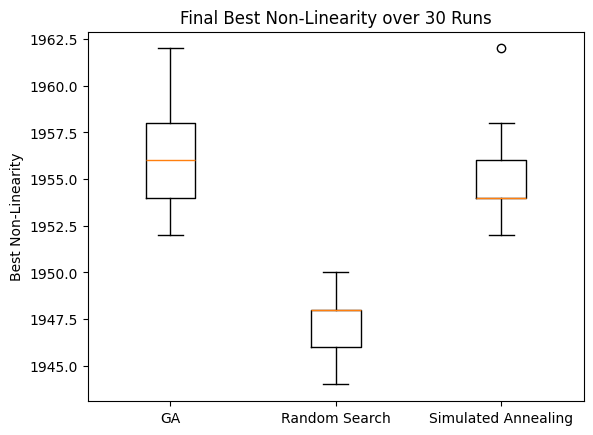

In [14]:
plt.boxplot(
    [ga_results, rs_results, sa_results],
    labels=["GA", "Random Search", "Simulated Annealing"]
)
plt.ylabel("Best Non-Linearity")
plt.title("Final Best Non-Linearity over 30 Runs")
plt.show()


In [15]:
def create_results_dict(scores: list[float]) -> dict[str, float]:
    res = {
        "scores": scores,
        "min": min(scores),
        "q1": float(np.percentile(scores, 25)),
        "median": statistics.median(scores),
        "q3": float(np.percentile(scores, 75)),
        "max": max(scores),
        "mean": statistics.mean(scores),
        "std": statistics.pstdev(scores)
    }
    return res


def is_kruskalwallis_passed(data: dict[str, list[float]], alpha: float = 0.05) -> bool:
    l = [data[key] for key in data]
    _, kruskal_pvalue = stats.kruskal(*l)
    return bool(kruskal_pvalue < alpha)


def is_mannwhitneyu_passed(data1: list[float], data2: list[float], alternative: str, alpha: float = 0.05) -> tuple[bool, float]:
    if data1 != data2:
        _, w_pval = stats.mannwhitneyu(data1, data2, alternative=alternative, method="auto")
        is_the_mannwhitney_test_meaningful: bool = bool(w_pval < alpha)
        return is_the_mannwhitney_test_meaningful, w_pval
    else:
        return False, 1.0


def perform_mannwhitneyu_holm_bonferroni(data: dict[str, list[float]], alternative: str, alpha: float = 0.05, method: str = 'holm') -> tuple[dict[str, bool], dict[str, dict[str, bool]]]:
    if len(data) <= 1:
        raise AttributeError(f'data must have at least two entries, found {len(data)} instead.')
    
    hb_res = {k1: False for k1 in data}
    mwu_res = {k1: {k2: False for k2 in data} for k1 in data}

    for method1 in data:
        a = data[method1]
        all_p_vals = []
        for method2 in data:
            if method2 != method1:
                b = data[method2]
                is_the_mannwhitney_test_meaningful, w_pval = is_mannwhitneyu_passed(a, b, alternative=alternative, alpha=alpha)
                all_p_vals.append(w_pval)
                mwu_res[method1][method2] = is_the_mannwhitney_test_meaningful
        all_p_vals.sort()
        reject_bonferroni, _, _, _ = multipletests(all_p_vals, alpha=alpha, method=method)
        is_the_bonferroni_test_meaningful: bool = bool(np.sum(reject_bonferroni) == len(all_p_vals))
        hb_res[method1] = is_the_bonferroni_test_meaningful
    
    if len(data) == 2:
        keys = sorted(list(data.keys()))
        first_method, second_method = keys[0], keys[1]
        hb_res[first_method] = mwu_res[first_method][second_method]
        hb_res[second_method] = mwu_res[second_method][first_method]

    return hb_res, mwu_res


In [16]:
ALPHA = 0.05

results = {
    "GA": ga_results,
    "RS": rs_results,
    "SA": sa_results
}

print("Kruskal-Wallis passed:", is_kruskalwallis_passed(results, alpha=ALPHA))

hb, pairwise = perform_mannwhitneyu_holm_bonferroni(
    results,
    alternative="greater",
    alpha=ALPHA
)

for method1 in pairwise:
    for method2 in pairwise:
        if method1 != method2:
            if pairwise[method1][method2]:
                print(f"{method1} leads to a non-linearity that is higher than the non-linearity of {method2} in a statistically significant way according to a Mann-Whitney U test.")

for method in hb:
    if hb[method]:
        print(f"{method} leads to the best non-linearity according to a Holm-Bonferroni correction!")


Kruskal-Wallis passed: True
GA leads to a non-linearity that is higher than the non-linearity of RS in a statistically significant way according to a Mann-Whitney U test.
GA leads to a non-linearity that is higher than the non-linearity of SA in a statistically significant way according to a Mann-Whitney U test.
SA leads to a non-linearity that is higher than the non-linearity of RS in a statistically significant way according to a Mann-Whitney U test.
GA leads to the best non-linearity according to a Holm-Bonferroni correction!


Results show that GA outperforms both SA and RS. In this context, evolving several solutions at a time is crucial to explore different areas of this immense, rugged, discrete, and multimodal search space.

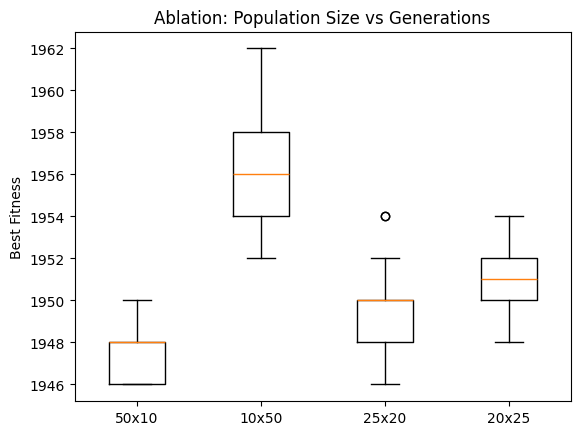

In [17]:
configs = [(50, 10), (10, 50), (25, 20), (20, 25)]
ablation_pg = {}

for pop, gen in configs:
    scores = []
    for seed in SEEDS:
        ga_solution, ga_score, ga_history = truth_tables_ea(
                n_bits=N_BITS,
                pop_size=pop,
                n_iter=gen,
                seed=seed,
                tournament_size=3,
                duplicates_elimination_retry=10,
                save_fitness_list_for_each_gen=False,
                verbose=False
        )
        scores.append(int(ga_score))
    ablation_pg[f"{pop}x{gen}"] = scores

plt.boxplot(ablation_pg.values(), labels=ablation_pg.keys())
plt.ylabel("Best Fitness")
plt.title("Ablation: Population Size vs Generations")
plt.show()


This ablation shows very clearly that, given a fixed computational budget, having smaller population size and higher number of generations is preferable. 

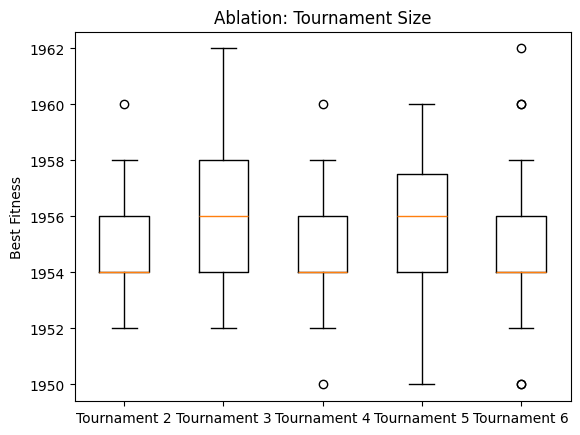

In [18]:
tournament_sizes = [2, 3, 4, 5, 6]
ablation_ts = {}

for ts in tournament_sizes:
    scores = []
    for seed in SEEDS:
        ga_solution, ga_score, ga_history = truth_tables_ea(
                n_bits=N_BITS,
                pop_size=POP_SIZE,
                n_iter=GENERATIONS,
                seed=seed,
                tournament_size=ts,
                duplicates_elimination_retry=10,
                save_fitness_list_for_each_gen=False,
                verbose=False
        )
        scores.append(int(ga_score))
    ablation_ts[f"Tournament {ts}"] = scores

plt.boxplot(ablation_ts.values(), labels=ablation_ts.keys())
plt.ylabel("Best Fitness")
plt.title("Ablation: Tournament Size")
plt.show()


Here, we see that the impact of tournament size is not meaningful. Probably, a small tournament size (3 or 4) represents the ideal choice.